### I. Dependencies

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import seaborn as sns

import numpy as np
np.random.seed(42)
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

print("All packages imported!")

All packages imported!


### II. Matplotlib Parameters

In [2]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 9

In [3]:
# Latex document Text width
latex_width = 390.0

def set_size(width=latex_width, height=latex_width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    Credit to Jack Walton for the function.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    """

    fig_width_pt = width * fraction
    fig_height_pt = height * fraction
    
    inches_per_pt = 1 / 72.27
    
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## III. Color Palette

The palette is from the [iWantHue](http://medialab.github.io/iwanthue/) website by Mathieu Jacomy at the Sciences-Po Medialab.

In [4]:
colors = [
    "#ba4c40",
    "#45c097",
    "#573485",
    "#a8ae3e",
    "#8874d9",
    "#69a050",
    "#be64b2",
    "#bc7d36",
    "#5d8ad4",
    "#b94973"
]

## 1. Social Experiment Datasets

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 102

**Demographic:** Students in the department of computer science and engineering at IIT Kharagpur

**Length of Experiments:** 1 Hour

**Experiment:** Participants were presented with a topic through an online platform developed by the researchers. The platform allowed for the participants to post a message to 10 randomly assigned social neighbours (which were kept constant) and use a slider with range $[-1,1]$ ($[-10,10]$ in datasets) to represent their current stance on the topic. Each time a participant posted a message, the value of the slider and timestamp was recorded. Participants were not allowed to use the internet or communicate with others verbally.

3 datasets were collected, each with a different topic presented to the participants:
- Europe (-1) vs North America (1)
- IIT, Delhi (-1) vs IIT, Bombay (1)
- Startup (-1) vs Job (1)

Topics where chosen such that the majority of agents had no strong prior opinion, to allow for some change over time.

<center> <h3>Dataset Contents</h3> </center>

<center> <h4><code>friends.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique participant identifier $\,$ | 09CS3015 |
| `friend_ID`$\,$ | String$\,$ | Unique participant identifier for a social neighbour $\,$ | 13CS60R26 |

<center> <h4><code>messages.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `id`$\,$ | String$\,$ | Unique participant identifier$\,$ | 10CS30007 |
| `timestamp`$\,$ | Unix Timestamp$\,$ | Time at which participant posted an opinion$\,$ | 1379494480 |
| `opinion`$\,$ | Float $\in [-10,10]$ $\,$ | Self-reported stance towards the topic$\,$ | 1.1 |

### Questions about the data:

- What does the timestamp in the message files correspond to? Epoch time
- What was the start and end time of the experiments?
- Does every participant post a message? In the college and occupation datasets, 1 participant does not post anything. Will be considered neutral (0 in the vectors)
- Why do the friend files have 1020 rows? There are 102 participants.
- At what timestamp do we set the initial opinions? At the very first one, assume all others are 0.
- How will opinions be aggregated to timesteps? 

### 1.1 Importing

In [5]:
FRIEND_HEADERS = ['ID', 'friend_ID']
MESSAGE_HEADERS = ['ID', 'timestamp', 'opinion']

social_experiments_filepath = os.path.join(os.getcwd(), 'data', 'experiment')

continent_filepath = os.path.join(social_experiments_filepath, 'europe-vs-america')
continent_friends =  pd.read_csv(os.path.join(continent_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
continent_messages = pd.read_csv(os.path.join(continent_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

college_filepath = os.path.join(social_experiments_filepath, 'iitd-vs-iitb')
college_friends = pd.read_csv(os.path.join(college_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
college_messages = pd.read_csv(os.path.join(college_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

occupation_filepath = os.path.join(social_experiments_filepath, 'startup-vs-job')
occupation_friends = pd.read_csv(os.path.join(occupation_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
occupation_messages = pd.read_csv(os.path.join(occupation_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

### 1.2 Cleaning

- All datatypes were correctly inferred
- There were no `NaN` values in the data.

#### Removing Duplicates from Message Datasets

All the `message.txt` datasets sets had duplicate rows which were removed. 

In [6]:
continent_duplicates = continent_messages[continent_messages.duplicated()]
continent_messages = continent_messages.drop_duplicates()

print(f'No. continent duplicates: {len(continent_duplicates)}')

No. continent duplicates: 38


In [7]:
college_duplicates = college_messages[college_messages.duplicated()]
college_messages = college_messages.drop_duplicates()

print(f'No. college duplicates: {len(college_duplicates)}')

No. college duplicates: 4


In [8]:
occupation_duplicates = occupation_messages[occupation_messages.duplicated()]
occupation_messages = occupation_messages.drop_duplicates()

print(f'No. occupation duplicates: {len(occupation_duplicates)}')

No. occupation duplicates: 21


### 1.3 Transforming Opinion Values

The Higham and Mantzaris network model has opinions ranged $[0,1]$, hence we must horizontally shift and compress the opinion values in the datasets. 

Trivially, we use $f(x) = \dfrac{x+10}{20}$.

In [9]:
continent_messages.opinion = (continent_messages.opinion + 10) / 20
college_messages.opinion = (college_messages.opinion + 10) / 20
occupation_messages.opinion = (occupation_messages.opinion + 10) / 20

### 1.4 Descriptive statistics

#### Europe vs North America (Continent)

In [10]:
continent_messages.describe()

,timestamp,opinion
count,2.144000e+03,2144.000000
mean,1.379496e+09,0.334841
std,8.469684e+02,0.276900
min,1.379494e+09,0.000000
25%,1.379495e+09,0.105000
50%,1.379496e+09,0.270000
75%,1.379497e+09,0.545000
max,1.379498e+09,1.000000


#### IIT, Delhi vs IIT, Bombay (College)

In [11]:
college_messages.describe()

,timestamp,opinion
count,1.754000e+03,1754.000000
mean,1.379501e+09,0.668213
std,5.720494e+02,0.268269
min,1.379500e+09,0.000000
25%,1.379500e+09,0.536250
50%,1.379500e+09,0.710000
75%,1.379501e+09,0.880000
max,1.379502e+09,1.000000


#### Startup vs Job (Occuptation)

In [12]:
occupation_messages.describe()

,timestamp,opinion
count,1.418000e+03,1418.000000
mean,1.379503e+09,0.444647
std,4.414919e+02,0.307805
min,1.379502e+09,0.000000
25%,1.379503e+09,0.161250
50%,1.379503e+09,0.402500
75%,1.379503e+09,0.703750
max,1.379504e+09,1.000000


### 1.5 Distribution of Opinions

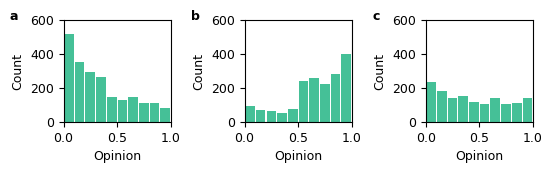

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3), height=350), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)


ax1.hist(continent_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,600)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Count')

ax2.hist(college_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,600)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Count')

ax3.hist(occupation_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,600)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Count')


ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

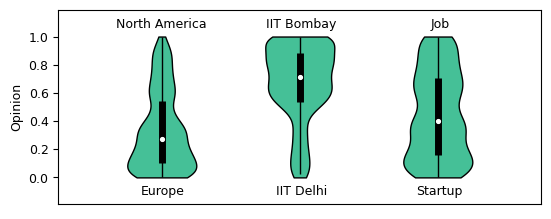

In [14]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height=150), constrained_layout=True)


def outlier_cutoff(vals, q1, q3):
    """
    Essentially outlier cutoff, but clipped so that it does not go out of range
    """
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


data = [sorted(continent_messages.opinion), sorted(college_messages.opinion), sorted(occupation_messages.opinion)]
labels = ['Continent', 'College', 'Occupation']


plot = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
ax.set_xlim(0.25, len(labels) + 0.75)
ax.set_ylim(-0.19,1.19)
#ax.set_xticks(np.arange(1, len(labels) + 1))
#ax.set_xticklabels(labels)
ax.set_xticks([])
ax.set_ylabel('Opinion')
for pc in plot['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
Q1s = [] 
medians = [] 
Q3s = []
for xs in data:
    Q1s.append(np.percentile(xs, 25))
    medians.append(np.percentile(xs, 50))
    Q3s.append(np.percentile(xs, 75))

    
whiskers = np.array([
    outlier_cutoff(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, Q1s, Q3s)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=7.5, zorder=3)
ax.vlines(inds, Q1s, Q3s, color='black', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='black', linestyle='-', lw=1)

ax.text(0.17, 0.1, 'Europe', transform=ax.transAxes, va='top')
ax.text(0.12, 0.96, 'North America', transform=ax.transAxes, va='top')

ax.text(0.45, 0.1, 'IIT Delhi', transform=ax.transAxes, va='top')
ax.text(0.43, 0.96, 'IIT Bombay', transform=ax.transAxes, va='top')

ax.text(0.74, 0.1, 'Startup', transform=ax.transAxes, va='top')
ax.text(0.77, 0.96, 'Job', transform=ax.transAxes, va='top')

#plt.savefig('social_opinion_violinplot.pdf', format='pdf', bbox_inches='tight')
plt.show()

Distribution is a kernel density estimation of the probability density function of the opinion values.

### 1.6 Setting the Initial Opinion Component 

As we do not have access to the exact start and end times of the experiment, I see two potential ways of deciding the participants initial opinion:

1. Assume the experiment starts when the first opinion is posted. All individuals who have not posted are assumed to be neutral (0.5). The downside here is that the participant may not have had time to express their opinion, and all individuals except the first one posting will be 0.5, which seems quite unrealistic.
2. Use the last message posted by a participant or 0.5 if no post from the first timestep to set the initial opinions of each participant. This is has the downside that individuals may already be influenced by others in the first timestep. Although, this is not really an issue, any person is constantly being influenced prior to the experiment from their enviroment. This is also easier to generalize in the programming.

I choose to move forward with the second option as it will likely give a better picture of the initial opinion distribution and it suffers from much less downsides than the first option. However, one must keep in mind that if the timesteps are too small, the second option will act just like the first one. **Ask supervisor about this**

In [15]:
def adjacency_matrix(friend_data):
    ids = friend_data.ID.unique()
    adj = np.zeros(shape=(len(ids),len(ids)), dtype=np.float64)
    for row in friend_data.iterrows():
        ID = row[1]['ID']
        friend_ID = row[1]['friend_ID']
        adj[np.where(ids==row[1]['ID'])[0][0],np.where(ids==row[1]['friend_ID'])[0][0]] = 1
    for i in range(len(ids)):
        adj[i] = adj[i] / np.sum(adj[i])
    return ids, adj

In [16]:
def opinion_timeseries(ids, msg_data, init_timestep, timestep):
    ops = [np.full(len(ids),0.5)]
    ts = []
    
    prev = msg_data.timestamp.min()
    cur = prev + init_timestep - 1 
    updates = msg_data[msg_data.timestamp.between(prev, cur)]
    opinions = ops[-1].copy()
    for i, ID in enumerate(ids):
        if ID in updates.ID.values:
            ID_updates = updates[updates.ID == ID]
            newest_idx = ID_updates.timestamp.idxmax()
            opinions[i] = ID_updates.loc[newest_idx].opinion
    ops.append(opinions)
    ts.append(cur)
    prev += init_timestep
    cur += init_timestep
        
    while prev <= msg_data.timestamp.max():
        updates = msg_data[msg_data.timestamp.between(prev, cur)]
        opinions = ops[-1].copy()
        for i, ID in enumerate(ids):
            if ID in updates.ID.values:
                ID_updates = updates[updates.ID == ID]
                newest_idx = ID_updates.timestamp.idxmax()
                opinions[i] = ID_updates.loc[newest_idx].opinion
                
        ops.append(opinions)
        ts.append(cur)
        prev += timestep
        cur += timestep
    return ts, ops[1:]

In [17]:
def opinion_info(friend_data, msg_data, init_timestep, timestep):
    ids, adj = adjacency_matrix(friend_data)
    ts, ops = opinion_timeseries(ids, msg_data, init_timestep, timestep)
    return ids, adj, ts, ops

### 1.7 Visualising Opinion Time Series

I tried computing the waterfall plot, however, as peoples opinions change so much, it does not look very continous. I also tried visualising the networks, however, they were too dense to find anything interesting. I did have success by recording the mean opinion value at each time step. There seems to be a convergence within the first ~8.3 minutes (500 seconds), where for all the experiments, the mean opinion value have lost there monotonous behaviour. 

Theta can be calculated from mean opinion plot, but can it be done mathematically?

In [36]:
init_timestep = 10
reg_timestep = 10

continent_ids, continent_adj, continent_ts, continent_ops = opinion_info(continent_friends, continent_messages, init_timestep, reg_timestep)

college_ids, college_adj, college_ts, college_ops = opinion_info(college_friends, college_messages, init_timestep, reg_timestep)

occupation_ids, occupation_adj, occupation_ts, occupation_ops = opinion_info(occupation_friends, occupation_messages, init_timestep, reg_timestep)

In [37]:
def means(xs):
    means = []
    for x in xs:
        means.append(np.mean(x))
    return means

continent_ops_means = means(continent_ops)
college_ops_means = means(college_ops)
occupation_ops_means = means(occupation_ops)

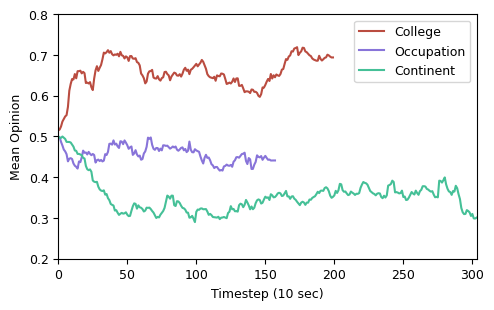

In [38]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(college_ops_means, color=colors[0], label='College')
ax.plot(occupation_ops_means, color=colors[4], label='Occupation')
ax.plot(continent_ops_means, color=colors[1], label='Continent')
ax.margins(x=0)
ax.set_ylim(0.2,0.8)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Mean Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [39]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [40]:
continent_stab_ts = 1379494929
continent_stab_timestep = find_nearest(continent_ts, continent_stab_ts)

college_stab_ts = 1379499937
college_stab_timestep = find_nearest(college_ts, college_stab_ts)

occupation_stab_ts = 1379502291
occupation_stab_timestep = find_nearest(occupation_ts, occupation_stab_ts)

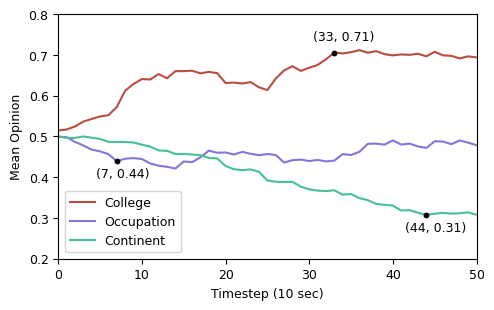

In [76]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(college_ops_means, color=colors[0], label='College')
ax.plot(occupation_ops_means, color=colors[4], label='Occupation')
ax.plot(continent_ops_means, color=colors[1], label='Continent')
ax.set_xlim(0,50)
ax.margins(x=0)
ax.set_ylim(0.2,0.8)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Mean Opinion')
ax.legend(loc='lower left')

ax.scatter([continent_stab_timestep],[continent_ops_means[continent_stab_timestep]], marker='o', s=10, zorder=3, color='black')
ax.annotate( f"({continent_stab_timestep}, {continent_ops_means[continent_stab_timestep]:.2f})", 
            (continent_stab_timestep - 2.5, continent_ops_means[continent_stab_timestep] - 0.04))


ax.scatter([college_stab_timestep],[college_ops_means[college_stab_timestep]], marker='o', s=10, zorder=3, color='black')
ax.annotate( f"({college_stab_timestep}, {college_ops_means[college_stab_timestep]:.2f})", 
            (college_stab_timestep - 2.5, college_ops_means[college_stab_timestep] + 0.03))

ax.scatter([occupation_stab_timestep],[occupation_ops_means[occupation_stab_timestep]], marker='o', s=10, zorder=3, color='black')
ax.annotate( f"({occupation_stab_timestep}, {occupation_ops_means[occupation_stab_timestep]:.2f})", 
            (occupation_stab_timestep - 2.5, occupation_ops_means[occupation_stab_timestep] - 0.04))


#plt.savefig('social_opinion_snapshot_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

The normal distribution of the opinions means is false.

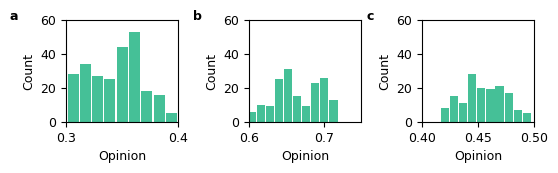

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3), height=350), constrained_layout=True)

ax1.hist(continent_ops_means[continent_stab_timestep:], bins=10, rwidth=0.9, color=colors[1])
ax1.set_xlim(0.3,0.4)
ax1.set_ylim(0,60)
ax1.margins(x=0)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Count')

ax2.hist(college_ops_means[college_stab_timestep:], bins=10, rwidth=0.9, color=colors[1])
ax2.set_xlim(0.6,0.75)
ax2.set_ylim(0,60)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Count')

ax3.hist(occupation_ops_means[occupation_stab_timestep:], bins=10, rwidth=0.9, color=colors[1])
ax3.set_xlim(0.4,0.5)
ax3.set_ylim(0,60)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Count')


ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 1.8 Estimating Theta from mean opinion

Lets calculate the statistics after testing this out

In [43]:
def means_to_theta(op_means, stability_timestep):
    return np.mean(op_means[stability_timestep:])

continent_mean_theta = means_to_theta(continent_ops_means, continent_stab_timestep)
college_mean_theta = means_to_theta(college_ops_means, college_stab_timestep)
occupation_mean_theta = means_to_theta(occupation_ops_means, occupation_stab_timestep)

### 1.9 Estimating epsilon from means of standard deviation

Lets calculate the statistics after testing it out

In [44]:
def stds(xs):
    stds = []
    for x in xs:
        stds.append(np.std(x))
    return stds

continent_ops_stds = stds(continent_ops)
college_ops_stds = stds(college_ops)
occupation_ops_stds = stds(occupation_ops)

In [45]:
def stds_to_epsilon(op_stds, stability_timestep):
    return np.mean(op_stds[stability_timestep:])

In [46]:
continent_std_epsilon = stds_to_epsilon(continent_ops_stds, continent_stab_timestep)
college_std_epsilon = stds_to_epsilon(college_ops_stds, college_stab_timestep)
occupation_std_epsilon = stds_to_epsilon(occupation_ops_stds, occupation_stab_timestep)

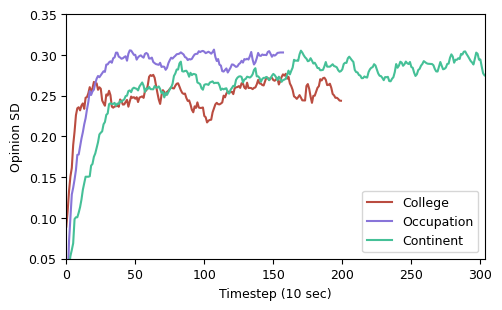

In [47]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(college_ops_stds, color=colors[0], label='College')
ax.plot(occupation_ops_stds, color=colors[4], label='Occupation')
ax.plot(continent_ops_stds, color=colors[1], label='Continent')
ax.margins(x=0)
ax.set_ylim(0.05,0.35)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Opinion SD')
ax.legend(loc='lower right')


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 1.10 Estimating r value from ???

### 1.11 Testing the model

In [48]:
def F(U, A, theta, r, epsilon):
    U_next = U + r * (theta - U) + epsilon * (U * (1 - U)) * (0.5 * (A @ U) - theta)
    return np.clip(U_next, 0, 1)

In [49]:
def pred_ops(init_ops, adj, theta, r, epsilon, duration):
    pred_ops = [init_ops]
    
    for _ in range(duration-1):
        new_ops = F(pred_ops[-1], adj, theta, r, epsilon)
        pred_ops.append(new_ops)
        
    return pred_ops

In [50]:
pred_continent_ops = pred_ops(continent_ops[0], continent_adj, continent_mean_theta, continent_mean_theta, continent_std_epsilon, len(continent_ops))
pred_continent_ops_means = means(pred_continent_ops)

pred_college_ops = pred_ops(college_ops[0], college_adj, college_mean_theta, college_mean_theta, college_std_epsilon, len(college_ops))
pred_college_ops_means = means(pred_college_ops)

pred_occupation_ops = pred_ops(occupation_ops[0], occupation_adj, occupation_mean_theta, occupation_mean_theta, occupation_std_epsilon, len(occupation_ops))
pred_occupation_ops_means = means(pred_occupation_ops)

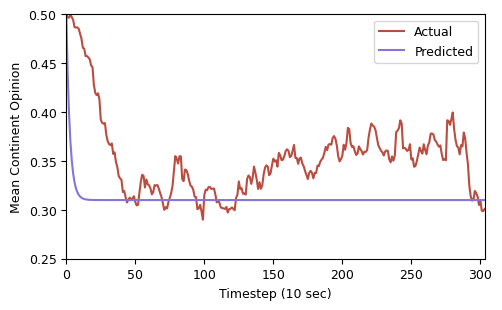

In [51]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(continent_ops_means, color=colors[0], label='Actual')
ax.plot(pred_continent_ops_means, color=colors[4], label='Predicted')
ax.margins(x=0)
ax.set_ylim(0.25,0.5)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Mean Continent Opinion')
ax.legend()

plt.show()

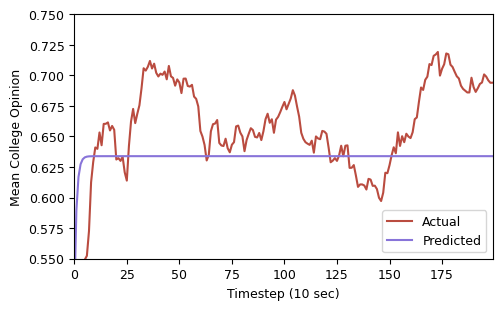

In [52]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(college_ops_means, color=colors[0], label='Actual')
ax.plot(pred_college_ops_means, color=colors[4], label='Predicted')
ax.margins(x=0)
ax.set_ylim(0.55,0.75)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Mean College Opinion')
ax.legend(loc='lower right')

plt.show()

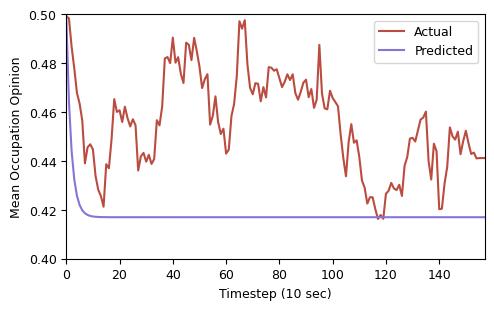

In [53]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(occupation_ops_means, color=colors[0], label='Actual')
ax.plot(pred_occupation_ops_means, color=colors[4], label='Predicted')
ax.margins(x=0)
ax.set_ylim(0.4,0.5)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Mean Occupation Opinion')
ax.legend(loc='upper right')

plt.show()

## 2. Twitter Dataset

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 548*; largest single connected component from the follow network constructed after filtering out corporate, bot and spammer accounts. 

**Demographic:** Anybody using the #BJP, #APP, #Congress, and #Polls2013 hashtags in tweets between the 9th and 15th December 2013. 

Look deeper into the characterisation of political orientation of Indian twitter users, and potential ramifications for our results.

**Dates on which tweets where collected:** 9th to 15th December 2013. The week after the results for the Delhi assembly election on the 8th December 2013.

**Explanation:** All tweets between the 9th and 15th December containing the hashtags #BJP, #APP, #Congress, and #Polls2013 were collected. This was the week after the results for the 2013 Delhi assembly election were released. The three first hashtags correspond to the three parties involved in the election, whilst the last hashtag is the one most strongly associated with the event. As the parties had recieved roughly equal votes, they needed to create a post-poll alliance for majority ruling, this led to many expressing their opinions on Twitter. To begin with ~905,000 tweets by ~201,000 users were collected. The users were then filtered for having between 100 and 10,000 friends; between 50 and 1,000 followers; and between 200 and 10,000 tweets. This was to remove corporate, bot and spammer accounts. The number of eligible users was ~55,000. By collecting the user IDs of all the followees and followers of these users, a follow network was constructed. Finally, the network studied is the largest single connected component where each user had posted over 20 tweets from the follow network. The opinion values were created hourly by taking the tweets of each user in that hour and adding it to a text document (no opinion if no tweets in that hour). These documents were then transformed to opinion scores $[-1,1]$ representing the attitude towards the political developments of the election. Specifically, the score represent the relative proportion of positive to negative connotative words in the document.

`* Filtering down from ~201,000 users.`

**Sentiment Analysis Tool:** A. Hannak, E. Anderson, L. F. Barrett, S. Lehmann,
A. Mislove, and M. Riedewald. Tweetin’ in the Rain:
Exploring societal-scale effects of weather on mood. In
*Proceedings of the 6th International AAAI Conference on
Weblogs and Social Media (ICWSM ’12)*, Dublin, Ireland,
June 2012.

#### Critique

- The sentiment analysis tool was initially intended for studying weather.
- The negative and positive connotations are associated with a small set of emoticons.
- How well does positive and negative connotation align a political axis in this situation? Often the difference between political parties is what they have negative and positive associations with, not that they are just negative or positive.


## 3. Reddit Dataset

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 556*

**Demographic:** Anybody who posted in the 'politics' subreddit between July 1 and December 31, 2012.

Look deeper into the characterisation of political orientation of Reddit Politics users, and potential ramifications for our results.

**Dates on which tweets where collected:** July 1 to December 31, 2012.

**Explanation:** All users who posted on the 'politics' subreddit between July 1 and December 31, 2012 were recorded. This resulted in ~31,000 users, from which a undirected user network was created, in which an edge means that the two users posted in two of the same subreddits in the given time period (excluding politics). The ~500 users were randomly selected such that they formed a single connected component where each user had over 20 submissions in the given time period. In contrast to the Twitter data, given that there is no character restrictions, most posts are made with well-formed english. This led to the use of the LIWC to calculate the opinion score. The opinion score of each post was equal to the normalised difference between the positive emotion score and the negative emotion score, where normalisation was mapping the range of values to $[-1,1]$ using linear scaling.

`* Filtering down from ~31,000 users.`


#### Critique

- Are people really friends / contacts if they post in the two same subreddits over a 6 month period?
- Most posts go unnoticed, how do we know that the users saw each others posts?